# Generate Approximate Hessians
Use the random displacement data to get the full Hessian matrix. We assume that many parameters of the Hessian matrix are zero, and therefore that we can fit the Hessian matrix with a reduced number of points using [sparse linear regression](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

In [112]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.linear import HarmonicModel
from sklearn.linear_model import LinearRegression, ElasticNetCV
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
import numpy as np
import warnings

Configuration

In [113]:
molecule_name = 'caffeine'
method = 'hf'
basis = 'def2-svpd'
step_size: float = 0.005 # Perturbation amount, used as maximum L2 norm
regressor = LinearRegression

Derived

In [114]:
run_name = f'{molecule_name}_{method}_{basis}'
out_dir = Path('data') / 'approx'
db_path = out_dir / f'{run_name}-random-d={step_size:.2e}.db'

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [115]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 751 structures


Read in the exact Hessian

In [116]:
with open(f'data/exact/{run_name}-ase.json') as fp:
    exact_vibs = VibrationsData.read(fp)

In [117]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()

## Fit a Hessian with All Data
Fit a model which explains the energy data by fitting a Hessian matrix using compressed sensing (i.e., Lasso).

In [118]:
model = HarmonicModel(reference=data[0], regressor=regressor)
hess_model = model.train(data)

In [119]:
print(f'Trained a model with {len(hess_model.coef_)} terms. {(np.abs(hess_model.coef_) > 1e-7).sum()} are nonzero')

Trained a model with 2700 terms. 2700 are nonzero


Compare the forces estimated at a zero displacement to the true value

In [120]:
actual_forces = data[0].get_forces()

In [121]:
pred_forces = -hess_model.coef_[:actual_forces.size].reshape((-1, 3))

In [122]:
print(f'Maximum force: {np.abs(pred_forces).max():.2e} eV/Angstrom')

Maximum force: 5.57e+00 eV/Angstrom


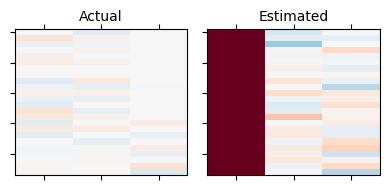

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Actual', 'Estimated'], [actual_forces, pred_forces]):
    ax.matshow(h, vmin=-0.05, vmax=0.05, aspect='auto', cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the mean Hessian

In [124]:
approx_hessian = model.mean_hessian(hess_model)

Compare to exact answer

In [125]:
exact_hess[:3, :3]

array([[1.96495560e+01, 2.28518485e+01, 1.08009177e-03],
       [2.28518485e+01, 8.36964299e+01, 3.94902961e-03],
       [1.08009177e-03, 3.94902961e-03, 4.15881408e+00]])

In [126]:
approx_hessian[:3, :3]

array([[3.26945590e+01, 4.95882374e+00, 8.59920621e-03],
       [4.95882374e+00, 3.93490213e+01, 6.10182117e-01],
       [8.59920621e-03, 6.10182117e-01, 2.73150623e+01]])

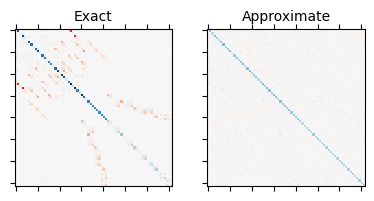

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the zero point energy

In [128]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)

In [129]:
approx_vibs.get_zero_point_energy()

7.268532902551082

In [130]:
exact_zpe

5.5067174465850215

The two differ, but I'm not sure how important the difference is.

## Plot as a Function of Data
See what happens as we add more data to the training

In [131]:
steps = np.linspace(5, len(data), 16, dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 16 steps: 5, 54, 104, 154, 203, ...


In [ ]:
zpes = []
for count in tqdm(steps):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hess_model = model.train(data[:count])
    
    approx_hessian = model.mean_hessian(hess_model)
    approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
    zpes.append(approx_vibs.get_zero_point_energy())

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10/16 [00:00<00:00, 16.03it/s]

Plot it

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(steps, zpes)

ax.set_xlim([0, steps.max()])
ax.plot(ax.get_xlim(), [exact_zpe]*2, 'k--')

ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (eV)')

fig.tight_layout()

We consistently underestimate the ZPE. Is it because we have too few oscillators?